# Submarine features generator (+tectonic faults model +submarine height model)

In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.metrics import accuracy_score
import random

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.max_columns', 500)

#Personal library for some machine learning alg. implementations
import myML

## Notes
Input must be the heightmap with water colored black RGB(0,0,0), sea level at 128, land starts at 129.

## Tectonic faults

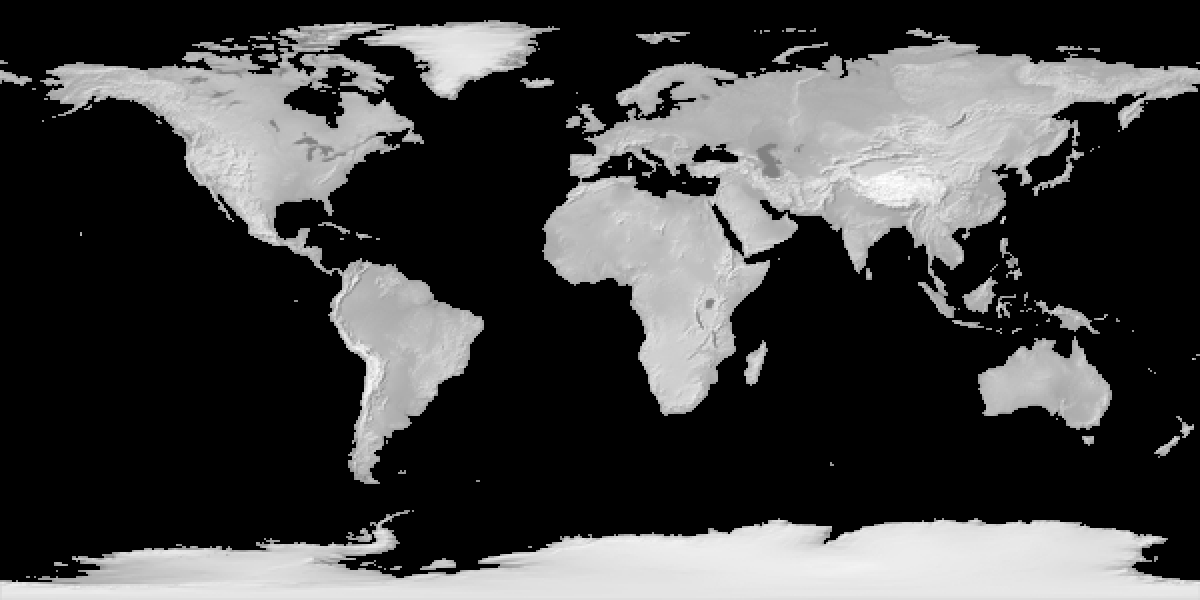

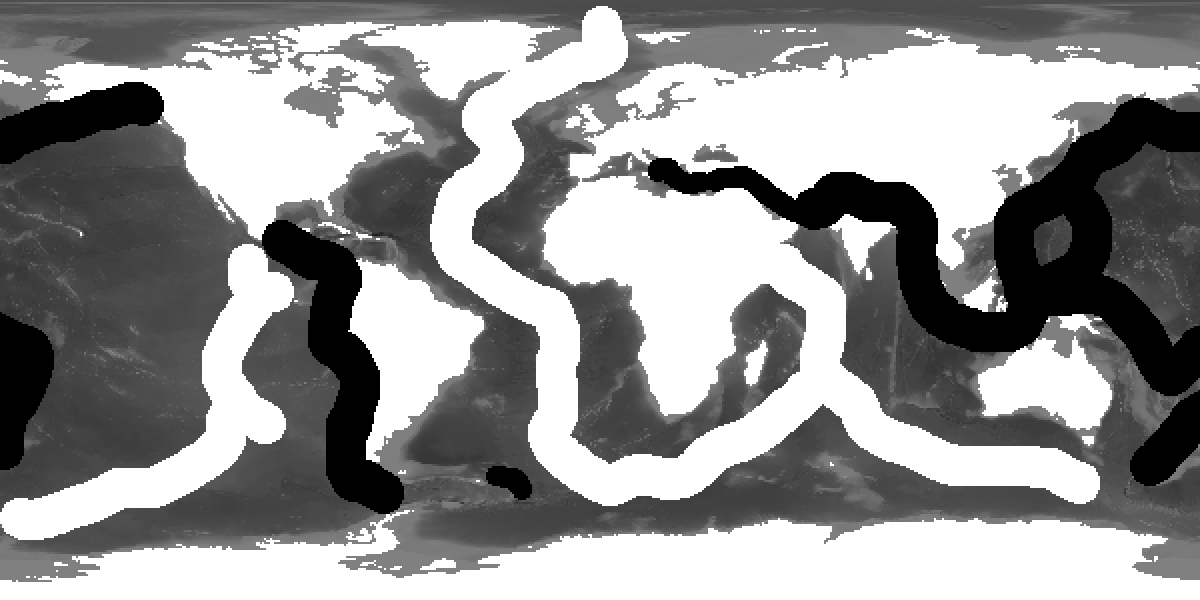

In [2]:
# Load black-LAND (RGB 0,0,0) and white-SEA (RGB 255 255 255) image in grayscale mode
imX = Image.open(r"training/X.png","r").convert('L')
imY1 = Image.open(r"training/Y1.png","r").convert('L')
display(imX.resize((1200,600), Image.Resampling.NEAREST))
display(imY1.resize((1200,600), Image.Resampling.NEAREST))

#### Normalizing image to land>=129

In [3]:
imData = np.array(imX)
temp = np.min(imData[imData>0]), np.max(imData)
temp = ((imData-temp[0])/(temp[1]-temp[0])*96+129).astype(np.uint8)
for y0 in range(imData.shape[0]):
    for x0 in range(imData.shape[1]):
        if imData[y0,x0]>0:
            imData[y0,x0] = temp[y0,x0]

#### Building first two datasets

In [4]:
def radiusFinder(x0, imData, minPoints):
    temp = []
    lims = imData.shape
    step = 5
    for y0 in range(imData.shape[0]):
        count = 0
        for r in range(2,10000,step):
            xlim = [max(0, x0-r), min(lims[1]-1, x0+r)]
            ylim = [max(0, y0-r), min(lims[0]-1, y0+r)]

            count = len(np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)[0])
            
            if count>minPoints:
                temp2 = r
                break
        if temp2==2: temp.append(temp2)
        else:
            for r in range(temp2+1-step,temp2+1):
                xlim = [max(0, x0-r), min(lims[1]-1, x0+r)]
                ylim = [max(0, y0-r), min(lims[0]-1, y0+r)]

                count = len(np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)[0])
                
                if count>minPoints: break
            temp.append(r)
            
    return temp

def inner_loop(x0, imData, imData2, convergent, divergent, adaptiveRadius, minPoints):
    temp = []
    lims = imData.shape
    res = np.sqrt(lims[0]**2+lims[1]**2)
    for y0 in range(imData.shape[0]):
        radius = adaptiveRadius[y0,x0]
        xlim = [max(0, x0-1-radius), min(lims[1]-1, x0+1+radius)]
        ylim = [max(0, y0-1-radius), min(lims[0]-1, y0+1+radius)]
        
        temp2 = np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)
        landcount = len(temp2[0])
        watercount = (1+ylim[1]-ylim[0])*(1+xlim[1]-xlim[0])-landcount

        ranges = ylim[1]-ylim[0], xlim[1]-xlim[0]
        center = (y0-ylim[0])/ranges[0], (x0-xlim[0])/ranges[1]
        xlist, ylist = temp2[1]/ranges[1], temp2[0]/ranges[0]

        distances = np.linalg.norm([xlist-center[1],ylist-center[0]], axis=0)
        nearest = np.argsort(distances)[1:minPoints+1]
        mindist = np.sqrt(((xlist[nearest[1]]-center[1])*ranges[1])**2+((ylist[nearest[1]]-center[0])*ranges[0])**2)/res
        heights = [imData[ylim[0]+temp2[0][index],xlim[0]+temp2[1][index]] for index in nearest]
        x_train = np.concatenate(([watercount/(watercount+landcount), mindist], (xlist-center[1])[nearest], (ylist-center[0])[nearest], np.array(heights)))

        if imData2[y0,x0]==convergent: y_train = [1,0,0]
        elif imData2[y0,x0]==divergent: y_train = [0,1,0]
        else: y_train = [0,0,1]

        temp.append([x_train, y_train])

    return temp

In [5]:
convergent = 0
divergent = 255
water = 0
minPoints = 10

imData = np.array(imX)
imData2 = np.array(imY1)
adaptiveRadius = np.zeros_like(imX)
result = Parallel(n_jobs=-1)(delayed(radiusFinder)(x0, imData, minPoints) for x0 in tqdm(range(imData.shape[1])))

for i, value in enumerate(result):
    adaptiveRadius[:,i] = value

  0%|          | 0/600 [00:00<?, ?it/s]

In [6]:
result = Parallel(n_jobs=-1)(delayed(inner_loop)(x0, imData, imData2, convergent, divergent, adaptiveRadius, minPoints) for x0 in tqdm(range(imData.shape[1])))

x_train, y_train = np.zeros((imData.shape[0]*imData.shape[1],minPoints*3+2)), np.zeros((imData.shape[0]*imData.shape[1],3))

count = 0
for x0 in result:
    for elem in x0:
        x_train[count,:], y_train[count,:] = elem[0], elem[1]
        count+=1

x_train = pd.DataFrame(x_train,columns=['Water percent','Mindist']+[f'x{i}' for i in range(minPoints)]+[f'y{i}' for i in range(minPoints)]+[f'h{i}' for i in range(minPoints)])
y_train = pd.DataFrame(y_train,columns=['Convergent', 'Divergent', 'Normal'])
pd.concat([x_train,y_train], axis=1).head(3)

  0%|          | 0/600 [00:00<?, ?it/s]

,Water percent,Mindist,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,Convergent,Divergent,Normal
0,0.981224,0.046212,0.029412,0.0,0.029412,0.058824,0.088235,0.794118,0.852941,0.823529,0.882353,0.852941,0.882353,0.911765,0.911765,0.911765,0.911765,1.000000,0.970588,1.000000,0.970588,1.000000,146.0,168.0,163.0,156.0,147.0,149.0,163.0,186.0,171.0,194.0,0.0,0.0,1.0
1,0.983193,0.044721,0.030303,0.0,0.030303,0.060606,0.090909,0.818182,0.878788,0.848485,0.909091,0.878788,0.852941,0.882353,0.882353,0.882353,0.882353,0.970588,0.941176,0.970588,0.941176,0.970588,146.0,168.0,163.0,156.0,147.0,149.0,163.0,186.0,171.0,194.0,0.0,0.0,1.0
2,0.973039,0.043231,0.030303,0.0,0.030303,0.060606,0.090909,0.000000,0.030303,0.696970,0.727273,0.757576,0.800000,0.828571,0.828571,0.828571,0.828571,0.942857,0.942857,0.942857,0.942857,0.942857,146.0,168.0,163.0,156.0,147.0,179.0,159.0,171.0,170.0,176.0,0.0,0.0,1.0


In [7]:
temp = max(len(x_train.index[y_train['Convergent']==1].to_list()), len(x_train.index[y_train['Convergent']==1].to_list()))
temp = len(x_train.index[y_train['Normal']==1].to_list()) - temp
temp = np.random.choice(x_train.index[y_train['Normal']==1].to_list(), size=temp, replace=False)
x_train2 = x_train.loc[~x_train.index.isin(temp)].reset_index(drop=True)
y_train2 = y_train.loc[~y_train.index.isin(temp)].reset_index(drop=True)

temp = np.arange(len(x_train2))
np.random.shuffle(temp)
x_train2.iloc[:,:] = x_train2.iloc[temp,:]
y_train2.iloc[:,:] = y_train2.iloc[temp,:]

pd.concat([x_train2,y_train2], axis=1).head(3)

,Water percent,Mindist,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,Convergent,Divergent,Normal
0,0.978817,0.031020,0.444444,0.472222,0.500000,0.416667,0.444444,0.472222,0.500000,0.416667,0.444444,0.388889,-0.361111,-0.333333,-0.305556,-0.416667,-0.388889,-0.361111,-0.333333,-0.444444,-0.416667,-0.472222,162.0,195.0,186.0,173.0,192.0,190.0,170.0,204.0,207.0,169.0,0.0,0.0,1.0
1,0.000000,0.001491,0.000000,0.166667,-0.166667,0.000000,0.166667,-0.166667,0.166667,-0.166667,0.000000,0.333333,0.166667,0.000000,0.000000,-0.166667,0.166667,0.166667,-0.166667,-0.166667,0.333333,0.000000,181.0,180.0,181.0,182.0,176.0,180.0,185.0,180.0,179.0,181.0,0.0,1.0,0.0
2,0.592593,0.002108,0.000000,-0.125000,-0.250000,0.000000,-0.250000,-0.125000,0.125000,-0.250000,-0.375000,0.000000,0.125000,0.125000,0.000000,0.250000,0.125000,0.250000,0.250000,0.250000,0.000000,0.375000,171.0,180.0,176.0,174.0,186.0,183.0,168.0,196.0,178.0,177.0,0.0,0.0,1.0


#### Training model

In [ ]:
epochs = 400        #Times that the entire dataset is used to train the NN
lr = 0.1            #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','ReLU','softmax']
lossname = 'logloss'
optimizer = 'Adam'

generations=100
popsize=10

ni = 1
nf = 20
step = 2
yplot_train = [[] for _ in range(2)]
for i in tqdm(range(0, nf-ni+1, step)):
    nodes = [minPoints*3+2, i+ni, i+ni, 3]

    neuralnetwork = myML.ANN(nodes, activation, lossname)
    neuralnetwork.defineNorm('Input', maximum=x_train2.max(), minimum=x_train2.min())
    
    _ = neuralnetwork.trainGA(x_train2, y_train2, generations=generations, popsize=popsize, tqdmDisable=True)
    costs = neuralnetwork.train(x_train2, y_train2, epochs, optimizer, lr, lambd, tqdmDisable=True, batchSize=0, trainTestSplit=0.9)
    yplot_train[0].append(costs[0][-1]), yplot_train[1].append(costs[1][-1])
    #yplot_train[0].append(accuracy_score(y_train2, np.round(neuralnetwork.run(x_train2))))

plt.plot(range(ni, nf-ni+1, step),yplot_train[0],label='Training set error')
plt.plot(range(ni, nf-ni+1, step),yplot_train[1],label='Test set error')
plt.xlabel('Nº of neurons in hidden layer')
plt.ylabel('Cost function error')
plt.legend(loc='best')
plt.show()

Generations:   0%|          | 0/100 [t-00:00, eta-?, ?it/s]

Epochs:   0%|          | 0/1500 [t-00:00, eta-?, ?it/s]

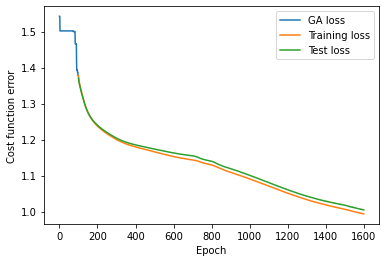

0.6970456881579413

In [8]:
epochs = 1500        #Times that the entire dataset is used to train the NN
lr = 0.001          #Learning rate
lambd = 0.5           #Regularization term
activation = ['ReLU','ReLU','softmax']
lossname = 'logloss'
optimizer = 'Adam'
nodes = [minPoints*3+2, 8, 8, 3]

generations=100
popsize=10

neuralnetwork = myML.ANN(nodes, activation, lossname)
neuralnetwork.defineNorm('Input', maximum=x_train2.max(), minimum=x_train2.min())

gaCost = neuralnetwork.trainGA(x_train2, y_train2, generations=generations, popsize=popsize)
costs = neuralnetwork.train(x_train2, y_train2, epochs, optimizer, lr, lambd, batchSize=0, trainTestSplit=0.8)

plt.plot(range(generations),gaCost, label='GA loss')
plt.plot(range(generations,generations+epochs),costs[0], label='Training loss')
plt.plot(range(generations,generations+epochs),costs[1], label='Test loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
#plt.yscale('log')
plt.ylabel('Cost function error')
plt.show()
accuracy_score(y_train2, np.round(neuralnetwork.run(x_train2)))

In [9]:
neuralnetwork.storeClass(name="training/faultmodel")

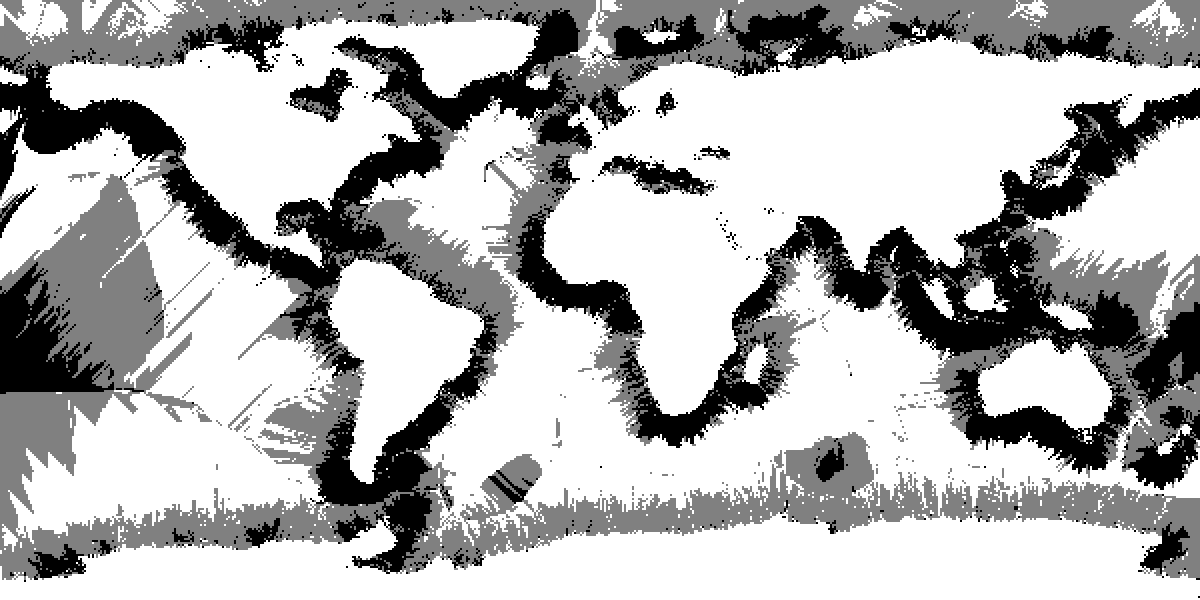

In [10]:
neuralnetwork = myML.ANN()
neuralnetwork.loadClass(name="training/faultmodel")

im = np.array(imX.copy())
points = neuralnetwork.run(x_train)
count = 0
for x in range(im.shape[1]):
    for y in range(im.shape[0]):
        temp = np.argmax(points[count,:])
        if temp==0: #Convergent
            im[y,x] = 0
        elif temp==1: #Divergent
            im[y,x] = 255
        else: im[y,x] = 128
        count+=1

im = Image.fromarray(im)
im.save('output files/step1.png')
display(im.resize((1200,600), Image.Resampling.NEAREST))

## Sea depth

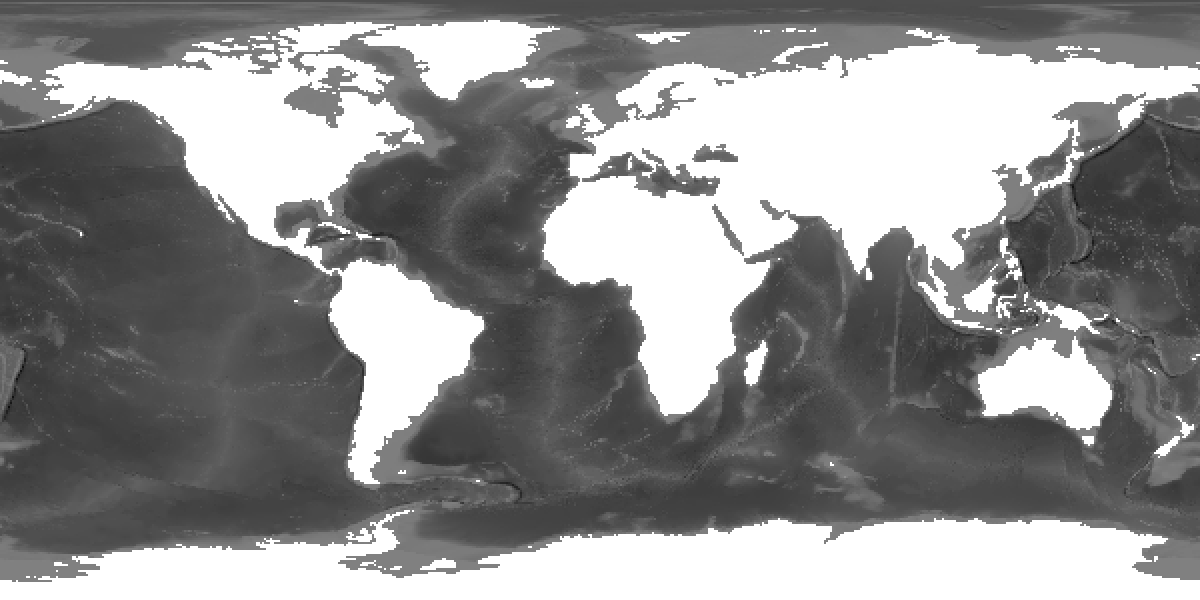

In [11]:
imY2 = Image.open(r"training/Y2.png","r").convert('L')
display(imY2.resize((1200,600), Image.Resampling.NEAREST))

In [12]:
def inner_loop(x0, imData, imData2, faults, water, radius):
    temp = []
    lims = imData.shape
    for y0 in range(imData.shape[0]):
        if imData[y0,x0]!=water: 
            temp.append([False])
            continue

        xlim = [max(0, x0-1-radius), min(lims[1]-1, x0+1+radius)]
        ylim = [max(0, y0-1-radius), min(lims[0]-1, y0+1+radius)]

        faulty = faults[ylim[0]:ylim[1]+1,xlim[0]:xlim[1]+1]
        x_train = [np.mean(faulty), np.std(faulty)]

        y_train = imData2[y0,x0]

        temp.append([x_train, y_train])

    return temp

In [13]:
water = 0

imData2 = np.array(imY2)
faults = np.array(im)/255
radius = int(np.ceil(np.sqrt(minPoints)))

result = Parallel(n_jobs=-1)(delayed(inner_loop)(x0, imData, imData2, faults, water, radius) for x0 in tqdm(range(imData.shape[1])))

x2_train, y2_train = np.zeros((imData.shape[0]*imData.shape[1],minPoints*3+4)), np.zeros((imData.shape[0]*imData.shape[1],1))
count = 0
count2 = 0
for x0 in result:
    for elem in x0:
        if elem[0] is not False:
            x2_train[count2,0:2], y2_train[count2,:] = elem[0], elem[1]
            x2_train[count2,2:] = x_train.iloc[count,:]
            count2+=1
        count+=1

x2_train = pd.DataFrame(x2_train,columns=['Fault mean', 'Fault std','Water percent','Mindist']+[f'x{i}' for i in range(minPoints)]+[f'y{i}' for i in range(minPoints)]+[f'h{i}' for i in range(minPoints)])
y2_train = pd.DataFrame(y2_train,columns=['Elevation'])
pd.concat([x2_train,y2_train], axis=1).head(3)

  0%|          | 0/600 [00:00<?, ?it/s]

,Fault mean,Fault std,Water percent,Mindist,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,Elevation
0,0.640305,0.223073,0.981224,0.046212,0.029412,0.0,0.029412,0.058824,0.088235,0.794118,0.852941,0.823529,0.882353,0.852941,0.882353,0.911765,0.911765,0.911765,0.911765,1.000000,0.970588,1.000000,0.970588,1.000000,146.0,168.0,163.0,156.0,147.0,149.0,163.0,186.0,171.0,194.0,78.0
1,0.679832,0.238639,0.983193,0.044721,0.030303,0.0,0.030303,0.060606,0.090909,0.818182,0.878788,0.848485,0.909091,0.878788,0.852941,0.882353,0.882353,0.882353,0.882353,0.970588,0.941176,0.970588,0.941176,0.970588,146.0,168.0,163.0,156.0,147.0,149.0,163.0,186.0,171.0,194.0,97.0
2,0.709477,0.245537,0.973039,0.043231,0.030303,0.0,0.030303,0.060606,0.090909,0.000000,0.030303,0.696970,0.727273,0.757576,0.800000,0.828571,0.828571,0.828571,0.828571,0.942857,0.942857,0.942857,0.942857,0.942857,146.0,168.0,163.0,156.0,147.0,179.0,159.0,171.0,170.0,176.0,82.0


In [14]:
temp = x2_train.index[x2_train['Water percent']==0].to_list()
x2_train2 = x2_train.loc[~x2_train.index.isin(temp)].reset_index(drop=True)
y2_train2 = y2_train.loc[~y2_train.index.isin(temp)].reset_index(drop=True)

temp = np.arange(len(x2_train2))
np.random.shuffle(temp)
x2_train2.iloc[:,:] = x2_train2.iloc[temp,:]
y2_train2.iloc[:,:] = y2_train2.iloc[temp,:]

pd.concat([x2_train2,y2_train2], axis=1).head(3)

,Fault mean,Fault std,Water percent,Mindist,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,Elevation
0,0.264560,0.426816,0.826446,0.004216,-0.200,-0.200000,-0.3000,-0.300000,-0.30,-0.400000,-0.400000,-0.4000,-0.400000,-0.400000,-0.10000,-0.200000,0.000000,-0.100000,-0.200000,0.000000,0.100000,-0.100000,-0.200000,-0.300000,176.0,155.0,167.0,181.0,169.0,178.0,154.0,179.0,181.0,158.0,126.0
1,0.112008,0.208992,0.785467,0.009068,0.375,0.375000,-0.0625,-0.125000,0.25,0.250000,-0.187500,0.4375,-0.062500,0.437500,0.00000,0.062500,-0.375000,-0.375000,0.312500,-0.312500,-0.375000,0.000000,0.437500,0.062500,147.0,148.0,159.0,164.0,150.0,158.0,146.0,172.0,159.0,167.0,126.0
2,1.000000,0.000000,0.985514,0.038873,0.500,0.478261,0.5000,0.478261,0.50,0.456522,0.478261,0.5000,0.456522,0.478261,-0.26087,-0.304348,-0.282609,-0.326087,-0.304348,-0.369565,-0.347826,-0.326087,-0.391304,-0.369565,169.0,174.0,196.0,192.0,215.0,147.0,210.0,205.0,171.0,211.0,68.0


  0%|          | 0/8 [00:00<?, ?it/s]

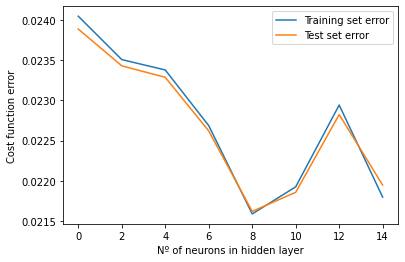

In [50]:
#Cross-validation using the training samples to find the elbow of the curve (to avoid under or overfitting)
epochs = 200        #Times that the entire dataset is used to train the NN
lr = 0.001            #Learning rate
lambd = 0           #Regularization term
activation = ['leakyReLU','leakyReLU','ReLU']
lossname = 'MSE'
optimizer = 'Adam'

generations=50
popsize=5

ni = 1
nf = 15
step = 2
yplot_train = [[] for _ in range(2)]
for i in tqdm(range(0, nf-ni+1, step)):
    nodes = [minPoints*3+4, i+ni, i+ni, 1]

    neuralnetwork = myML.ANN(nodes, activation, lossname)
    neuralnetwork.defineNorm('Input', maximum=x2_train2.max(), minimum=x2_train2.min())
    neuralnetwork.defineNorm('Output', maximum=y2_train2.max(), minimum=y2_train2.min())
    
    _ = neuralnetwork.trainGA(x2_train2, y2_train2, generations=generations, popsize=popsize, tqdmDisable=True)
    costs = neuralnetwork.train(x2_train2, y2_train2, epochs, optimizer, lr, lambd, tqdmDisable=True, batchSize=0)
    yplot_train[0].append(costs[0][-1]), yplot_train[1].append(costs[1][-1])

plt.plot(range(0, nf-ni+1, step),yplot_train[0],label='Training set error')
plt.plot(range(0, nf-ni+1, step),yplot_train[1],label='Test set error')
plt.xlabel('Nº of neurons in hidden layer')
plt.ylabel('Cost function error')
plt.legend(loc='best')
plt.show()

Generations:   0%|          | 0/100 [t-00:00, eta-?, ?it/s]

Epochs:   0%|          | 0/500 [t-00:00, eta-?, ?it/s]

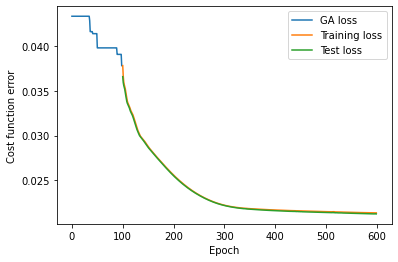

In [15]:
epochs = 500        #Times that the entire dataset is used to train the NN
lr = 0.001          #Learning rate
lambd = 0.5           #Regularization term
activation = ['ReLU','ReLU','ReLU']
lossname = 'MSE'
optimizer = 'Adam'
nodes = [minPoints*3+4, 8, 8, 1]

generations=100
popsize=10

neuralnetwork = myML.ANN(nodes, activation, lossname)
neuralnetwork.defineNorm('Input', maximum=x2_train2.max(), minimum=x2_train2.min())
neuralnetwork.defineNorm('Output', maximum=y2_train2.max(), minimum=y2_train2.min())

gaCost = neuralnetwork.trainGA(x2_train2, y2_train2, generations=generations, popsize=popsize)
costs = neuralnetwork.train(x2_train2, y2_train2, epochs, optimizer, lr, lambd, batchSize=0, trainTestSplit=0.8)

plt.plot(range(generations),gaCost, label='GA loss')
plt.plot(range(generations,generations+epochs),costs[0], label='Training loss')
plt.plot(range(generations,generations+epochs),costs[1], label='Test loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
#plt.yscale('log')
plt.ylabel('Cost function error')
plt.show()

In [16]:
neuralnetwork.storeClass(name="training/heightmodel")

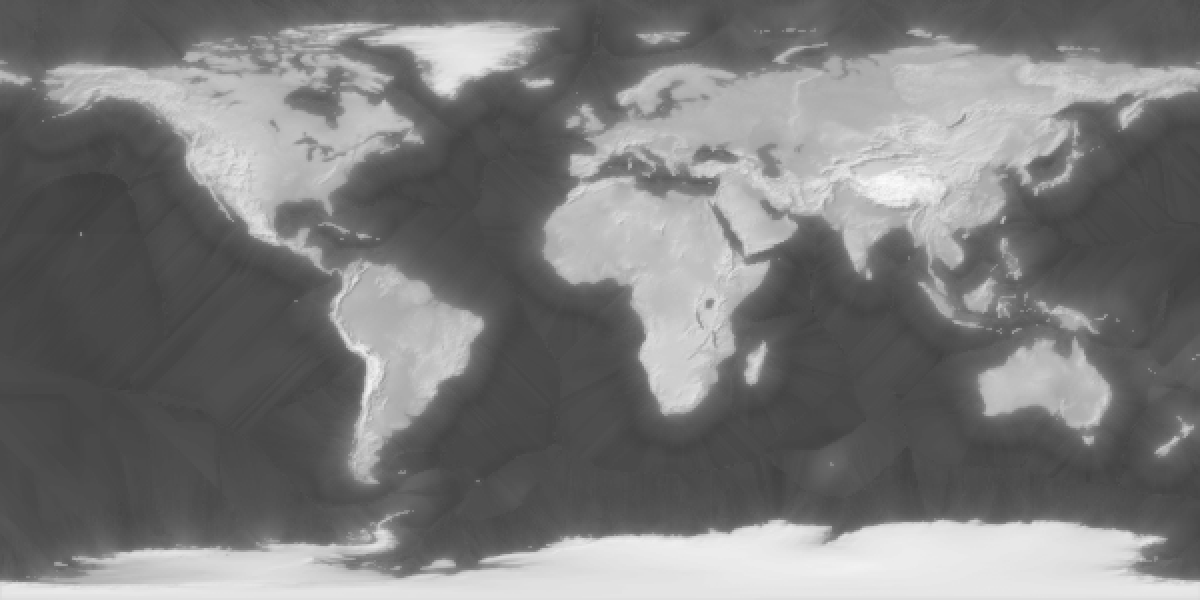

In [17]:
neuralnetwork = myML.ANN()
neuralnetwork.loadClass(name="training/heightmodel")

fullHeightmap = np.array(imX.copy())
points = neuralnetwork.run(x2_train)
count = 0
for x in range(fullHeightmap.shape[1]):
    for y in range(fullHeightmap.shape[0]):
        if imData[y,x]!=water: 
            fullHeightmap[y,x] = imData[y,x]
            continue
        fullHeightmap[y,x] = points[count,0]
        count+=1

# Application of gaussian blur with different radius to the diffused map + sum and normalization of the images
blur_radius = [0,1]
temp = sum([gaussian_filter(fullHeightmap, sigma=r)/len(blur_radius) for r in blur_radius])
fullHeightmap = np.round(temp).astype(np.uint8)

imDepth = Image.fromarray(fullHeightmap)
imDepth.save('output files/step2.png')
display(imDepth.resize((1200,600), Image.Resampling.NEAREST))

## Mountain peaks

  0%|          | 0/600 [00:00<?, ?it/s]

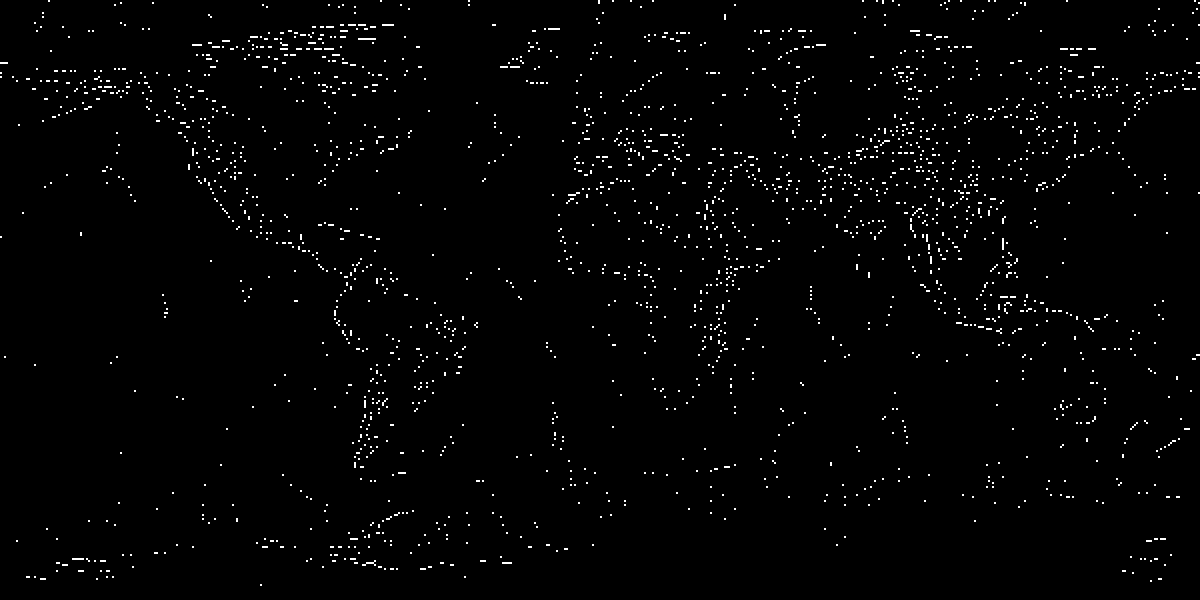

In [18]:
def peakFinder(x0, imData):
    temp = []
    lims = imData.shape
    for y0 in range(imData.shape[0]):
        xlim = [max(0, x0-1), min(lims[1]-1, x0+1)]
        ylim = [max(0, y0-1), min(lims[0]-1, y0+1)]

        color = imData[y0,x0]
        color = color-2 if color<127 else color*0.99

        count = len(np.where(imData[ylim[0]:ylim[1]+1,xlim[0]:xlim[1]+1]>color)[0])
        if count<=2: temp.append(255)
        else: temp.append(0)

    return temp

peakData = np.empty_like(imData)
result = Parallel(n_jobs=-1)(delayed(peakFinder)(x0, fullHeightmap) for x0 in tqdm(range(imData.shape[1])))

for x0, res in enumerate(result):
    for y0, value in enumerate(res):
        peakData[y0,x0] = value

Image.fromarray(peakData).save('output files/step3.png')
display(Image.fromarray(peakData).resize((1200,600), Image.Resampling.NEAREST))

## Erosion through Diffusion Limited Aggregation

  0%|          | 0/1000 [00:00<?, ?it/s]

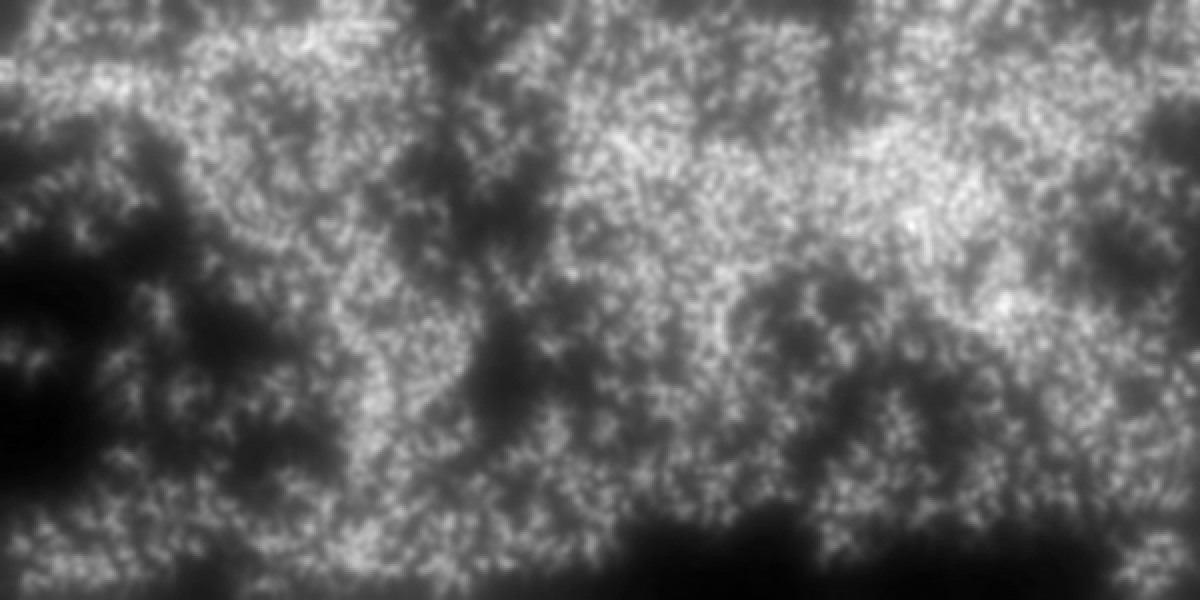

In [19]:
def peakFinder(pos, fullHeightmap, simState, seed):
    lims = simState.shape
    random.seed(seed)

    ydown, yup = [max(0, pos[0]-1), min(lims[0]-1, pos[0]+1)]
    xdown, xup = [max(0, pos[1]-1), min(lims[1]-1, pos[1]+1)]
        
    #Check boundary for seed
    if np.max(simState[ydown:yup+1,xdown:xup+1])>0: return [True, pos]

    weights = [fullHeightmap[yup,x0]+1,fullHeightmap[y0,xup]+1,fullHeightmap[ydown,x0]+1,fullHeightmap[y0,xdown]+1]
    paths = random.choices([0,1,2,3], weights=weights)[0]

    if paths==0: pos[0] = yup
    elif paths==1: pos[1] = xup
    elif paths==2: pos[0] = ydown
    else: pos[1] = xdown
    return [False, pos]

maxiter = 1000
diffused = peakData.copy()

temp = np.where(diffused==0)
particles = int(np.sqrt(len(temp[0]))*100)
threshold = int(np.sqrt(len(temp[0]))*4)
points = np.random.randint(0, len(temp[0]), particles)
points = [[temp[0][x],temp[1][x]] for x in points]
seeds = random.sample(range(particles), particles)#np.random.randint(0, 32000, particles, dtype=int)

pbar, nparticles = tqdm(range(maxiter)), particles
for _ in pbar:
    if nparticles<20000:
        result = []
        for i in range(nparticles):
            result.append(peakFinder(points[i], fullHeightmap, diffused, seeds[i]))
    else:
        result = Parallel(n_jobs=-1)(delayed(peakFinder)(points[i], fullHeightmap, diffused, seeds[i]) for i in range(nparticles))

    points = []
    for i,elem in enumerate(result):
        flag, pos = elem
        if flag: diffused[pos[0],pos[1]] = 255*nparticles/particles
        else: points.append(pos)

    nparticles = len(points)
    if nparticles<threshold:
        temp = np.where(diffused==0)
        if len(temp[0]>2000):
            points.extend([[temp[0][x],temp[1][x]] for x in np.random.randint(0, len(temp[0]), 2000)])
            nparticles+=2000
    pbar.set_postfix_str(f'nparticles: {nparticles}')
    if nparticles==0: break
    
random.seed()

# Application of gaussian blur with different radius to the diffused map + sum and normalization of the images
blur_radius = [2,8,16,32,64]
temp = sum([gaussian_filter(diffused, sigma=r)/len(blur_radius) for r in blur_radius])
diffused = np.round((temp-np.min(temp))*255/(np.max(temp)-np.min(temp))).astype(np.uint8)
Image.fromarray(diffused).save('output files/step4.png')
display(Image.fromarray(diffused).resize((1200,600), Image.Resampling.NEAREST))

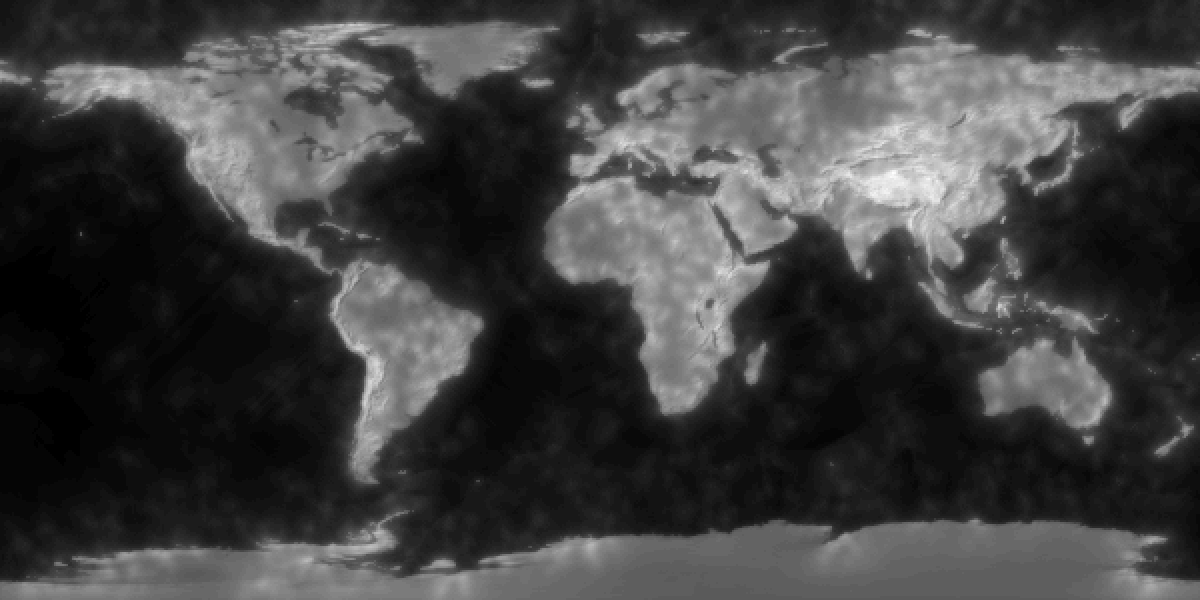

In [20]:
def func(x, parameter):
    return 1/(1+np.exp(-parameter*float(x-128)))

parameter = 0.018
erodedData = np.empty_like(imData)

for x0 in range(imData.shape[1]):
    for y0 in range(imData.shape[0]):
        value = fullHeightmap[y0,x0]
        erodedData[y0,x0] = value*func(temp[y0,x0],parameter)
erodedData = np.round((erodedData-np.min(erodedData))/(np.max(erodedData)-np.min(erodedData))*255).astype(np.uint8)
display(Image.fromarray(erodedData).resize((1200,600), Image.Resampling.NEAREST))
Image.fromarray(erodedData).save('output files/step5.png')

## Watercolor

  0%|          | 0/300 [00:00<?, ?it/s]

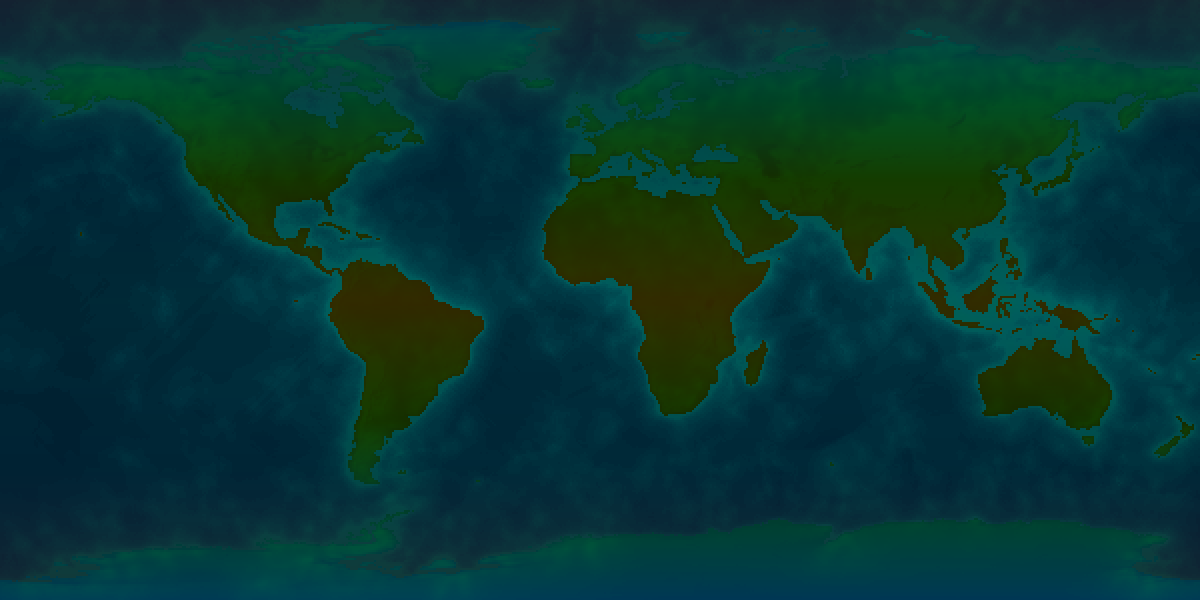

Remember to convert it to dds


In [21]:
def inner_loop(y0,imData,erodedData,waterlims,landlims,equator,temperate_center,artic_center,intermediate,m):
    temp2 = []
    equator_distance = abs(m*(y0/imData.shape[0]-equator)) #0 if at equator, 0.5 if at the poles 
    for x0 in range(imData.shape[1]):
        height = erodedData[y0,x0]
        
        water = imData[y0,x0]
        if water==0:
            # Sea
            height = height if height>waterlims[0] else waterlims[0]
            if equator_distance<intermediate: 
                red = 0
            else:
                red = int(20*(equator_distance-intermediate)/(0.5-intermediate))

            mingB = 0.73-0.17*equator_distance/0.5
            max1gB = 1
            max2gB = 1.24-0.24*equator_distance/0.5
            minmod = 60-5*equator_distance/0.5
            max1mod = 134-54*equator_distance/0.5
            max2mod = 130-50*equator_distance/0.5

            if height<=waterlims[1]:
                heightmod = minmod+(max1mod-minmod)*(height-waterlims[0])/(waterlims[1]-waterlims[0])
                gb = mingB+(max1gB-mingB)*(height-waterlims[0])/(waterlims[1]-waterlims[0])
            else: 
                heightmod = max1mod+(max2mod-max1mod)*(height-waterlims[1])/(waterlims[2]-waterlims[1])
                gb = max1gB+(max2gB-max1gB)*(height-waterlims[1])/(waterlims[2]-waterlims[1])
            
            blue = int(np.sqrt((heightmod**2-red**2)/(gb**2+1)))
            green = int(gb*blue)
        else:
            # Land
            height = height if height>landlims[0] else landlims[0]
            height = height if height<landlims[1] else landlims[1]
            if equator_distance<artic_center: 
                red = int(50*(artic_center-equator_distance)/artic_center)
            else:
                red = 0
            if equator_distance<=temperate_center:
                temp = equator_distance/temperate_center
                blue = 0
                maxmod = 67-4*temp
                minmod = 64-16*temp
            else:
                temp = (equator_distance-temperate_center)/(0.5-temperate_center)
                blue = int(85*temp)
                maxmod = 63+54*temp
                minmod = 48+53*temp

            heightmod = minmod+(maxmod-minmod)*(height-landlims[0])/(landlims[1]-landlims[0])
            green = int(np.sqrt(heightmod**2-blue**2-red**2))
        temp2.append([red, green, blue])
    return temp2

equator = 0.5 #If 0 is the top, 1 the bottom, where is the equator in your map?
temperate_center = 0.2 #If 0 is the equator, 0.5 the pole. You want this between Gibraltar and the Pirinees, or equivalent in your mod
artic_center = 0.34 #If 0 is the equator, 0.5 the pole. You want this around Helsinki in Finland, or equivalent in your mod
deviations = 1.5 #Deviations from the mean to make the ranges

temp = np.mean(erodedData[imData==0]), np.std(erodedData[imData==0])
waterlims = temp[0]-deviations*temp[1], temp[0]+deviations*temp[1], np.max(erodedData[imData==0])
temp = np.mean(erodedData[imData>0]), np.std(erodedData[imData>0])
landlims = temp[0]-deviations*temp[1], temp[0]+deviations*temp[1]

m = -0.5/equator
intermediate = (artic_center+temperate_center)/2
watercolor = np.stack((erodedData.copy(),)*3, axis=-1)

result = Parallel(n_jobs=-1)(delayed(inner_loop)(y0,imData,erodedData,waterlims,landlims,equator,temperate_center,artic_center,intermediate,m) for y0 in tqdm(range(imData.shape[0])))

for y0, res in enumerate(result):
    for x0, value in enumerate(res):
        watercolor[y0,x0,:] = value
    
display(Image.fromarray(watercolor).resize((1200,600), Image.Resampling.NEAREST))
Image.fromarray(watercolor).save('output files/watercolor_rgb_waterspec_a.png')
print('Remember to convert it to dds')